# Predicting a Wine’s Cultivator from its Chemical Characteristics

This dataset is a result of chemical analysis done on different wines grown in the same Italien region, but originating from 3 different cultivators. Each row contains the quantity of 13 different chemical constituents found in a wine from a particular cultivator. This model will attempt to use these measurements to predict a wine’s cultivator, answering the question: “based on the chemical composition of a wine, can its origin be determined?”

Please note no units were provided in the dataset or website.

In [88]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(httr)
library(GGally)
library(grid)

In [2]:
set.seed(9999)

# read data
wine_path <- 'https://raw.githubusercontent.com/JadenMajid/dsci-100-student-grades/main/wine.data'

wine_data <- read_delim(file = wine_path, delim = ",", col_names = FALSE) |>
    mutate(X1 = as_factor(X1)) |>
    select(-X14)

# column names obtained from UCI Ml website
colnames(wine_data) <- c('alcohol', 'malic_acid', 'ash', 'alcalinity', 'magnesium', 'total_phenols',
                         'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity',
                         'hue', 'ODnum', 'proline')
# split data
split <- wine_data |>
    initial_split(prop = 0.75, strata = alcohol)

wine_training_data <- training(split)
wine_test_data <- testing(split)

Rows: 178 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Preliminary Exploratory Data Analysis
The following 3 tables show the mean, maximum, and minimum for each chemical compound measured in the wines.

In [43]:
# mean
mean_stats <- wine_training_data |>
    group_by(alcohol) |>
    summarize(across(malic_acid:proline, mean))

print("Table [1]")
mean_stats

[1] "Table [1]"


alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,ODnum,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,13.75932,1.859318,2.455227,16.84318,105.75000,2.852500,2.9877273,0.2840909,1.915227,5.478636,1.0700000,3.186136
2,12.26792,2.030377,2.226038,20.03774,95.60377,2.280943,2.0996226,0.3547170,1.633208,3.086981,1.0452075,2.809811
3,13.12861,3.369444,2.439167,21.40278,99.72222,1.615556,0.7622222,0.4369444,1.062778,6.859722,0.6972222,1.699722


In [40]:
# max
max_stats <- wine_training_data |>
    group_by(alcohol) |>
    summarize(across(malic_acid:proline, max))
print("Table [2]")
max_stats

[1] "Table [2]"


alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,ODnum,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14.83,3.59,2.87,22.5,127,3.85,3.93,0.43,2.96,8.7,1.28,4.00
2,13.67,5.80,3.23,30.0,162,3.52,5.08,0.66,3.58,6.0,1.71,3.69
3,14.16,5.51,2.75,27.0,123,2.32,1.57,0.63,1.56,10.8,0.96,2.47


In [44]:
# minimum
min_stats <- wine_training_data |>
    group_by(alcohol) |>
    summarize(across(malic_acid:proline, min))
print("Table [3]")
min_stats

[1] "Table [3]"


alcohol,malic_acid,ash,alcalinity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,ODnum,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,12.85,1.35,2.10,11.2,91,2.35,2.19,0.17,1.25,3.52,0.86,2.51
2,11.03,0.89,1.36,10.6,70,1.10,0.57,0.13,0.41,1.28,0.69,1.59
3,12.20,1.24,2.15,17.5,80,0.98,0.34,0.21,0.55,3.85,0.48,1.27


In [47]:
# number of wines from each region
counts <- wine_training_data |>
    group_by(alcohol) |>
    summarize(count = n(), proportion = n() / nrow(wine_training_data))
print("Table [4]")
counts


[1] "Table [4]"


alcohol,count,proportion
<fct>,<int>,<dbl>
1,44,0.3308271
2,53,0.3984962
3,36,0.2706767


The table above shows the proportion and count of the number of wines from each of the three regions chosen for this experiment.

### Exploratory Visualization
To better understand the data, all pairs of chemical compounds are plotted against each other, colored by their origins. This highlights any variables that may be good predictors of wine cultivator.

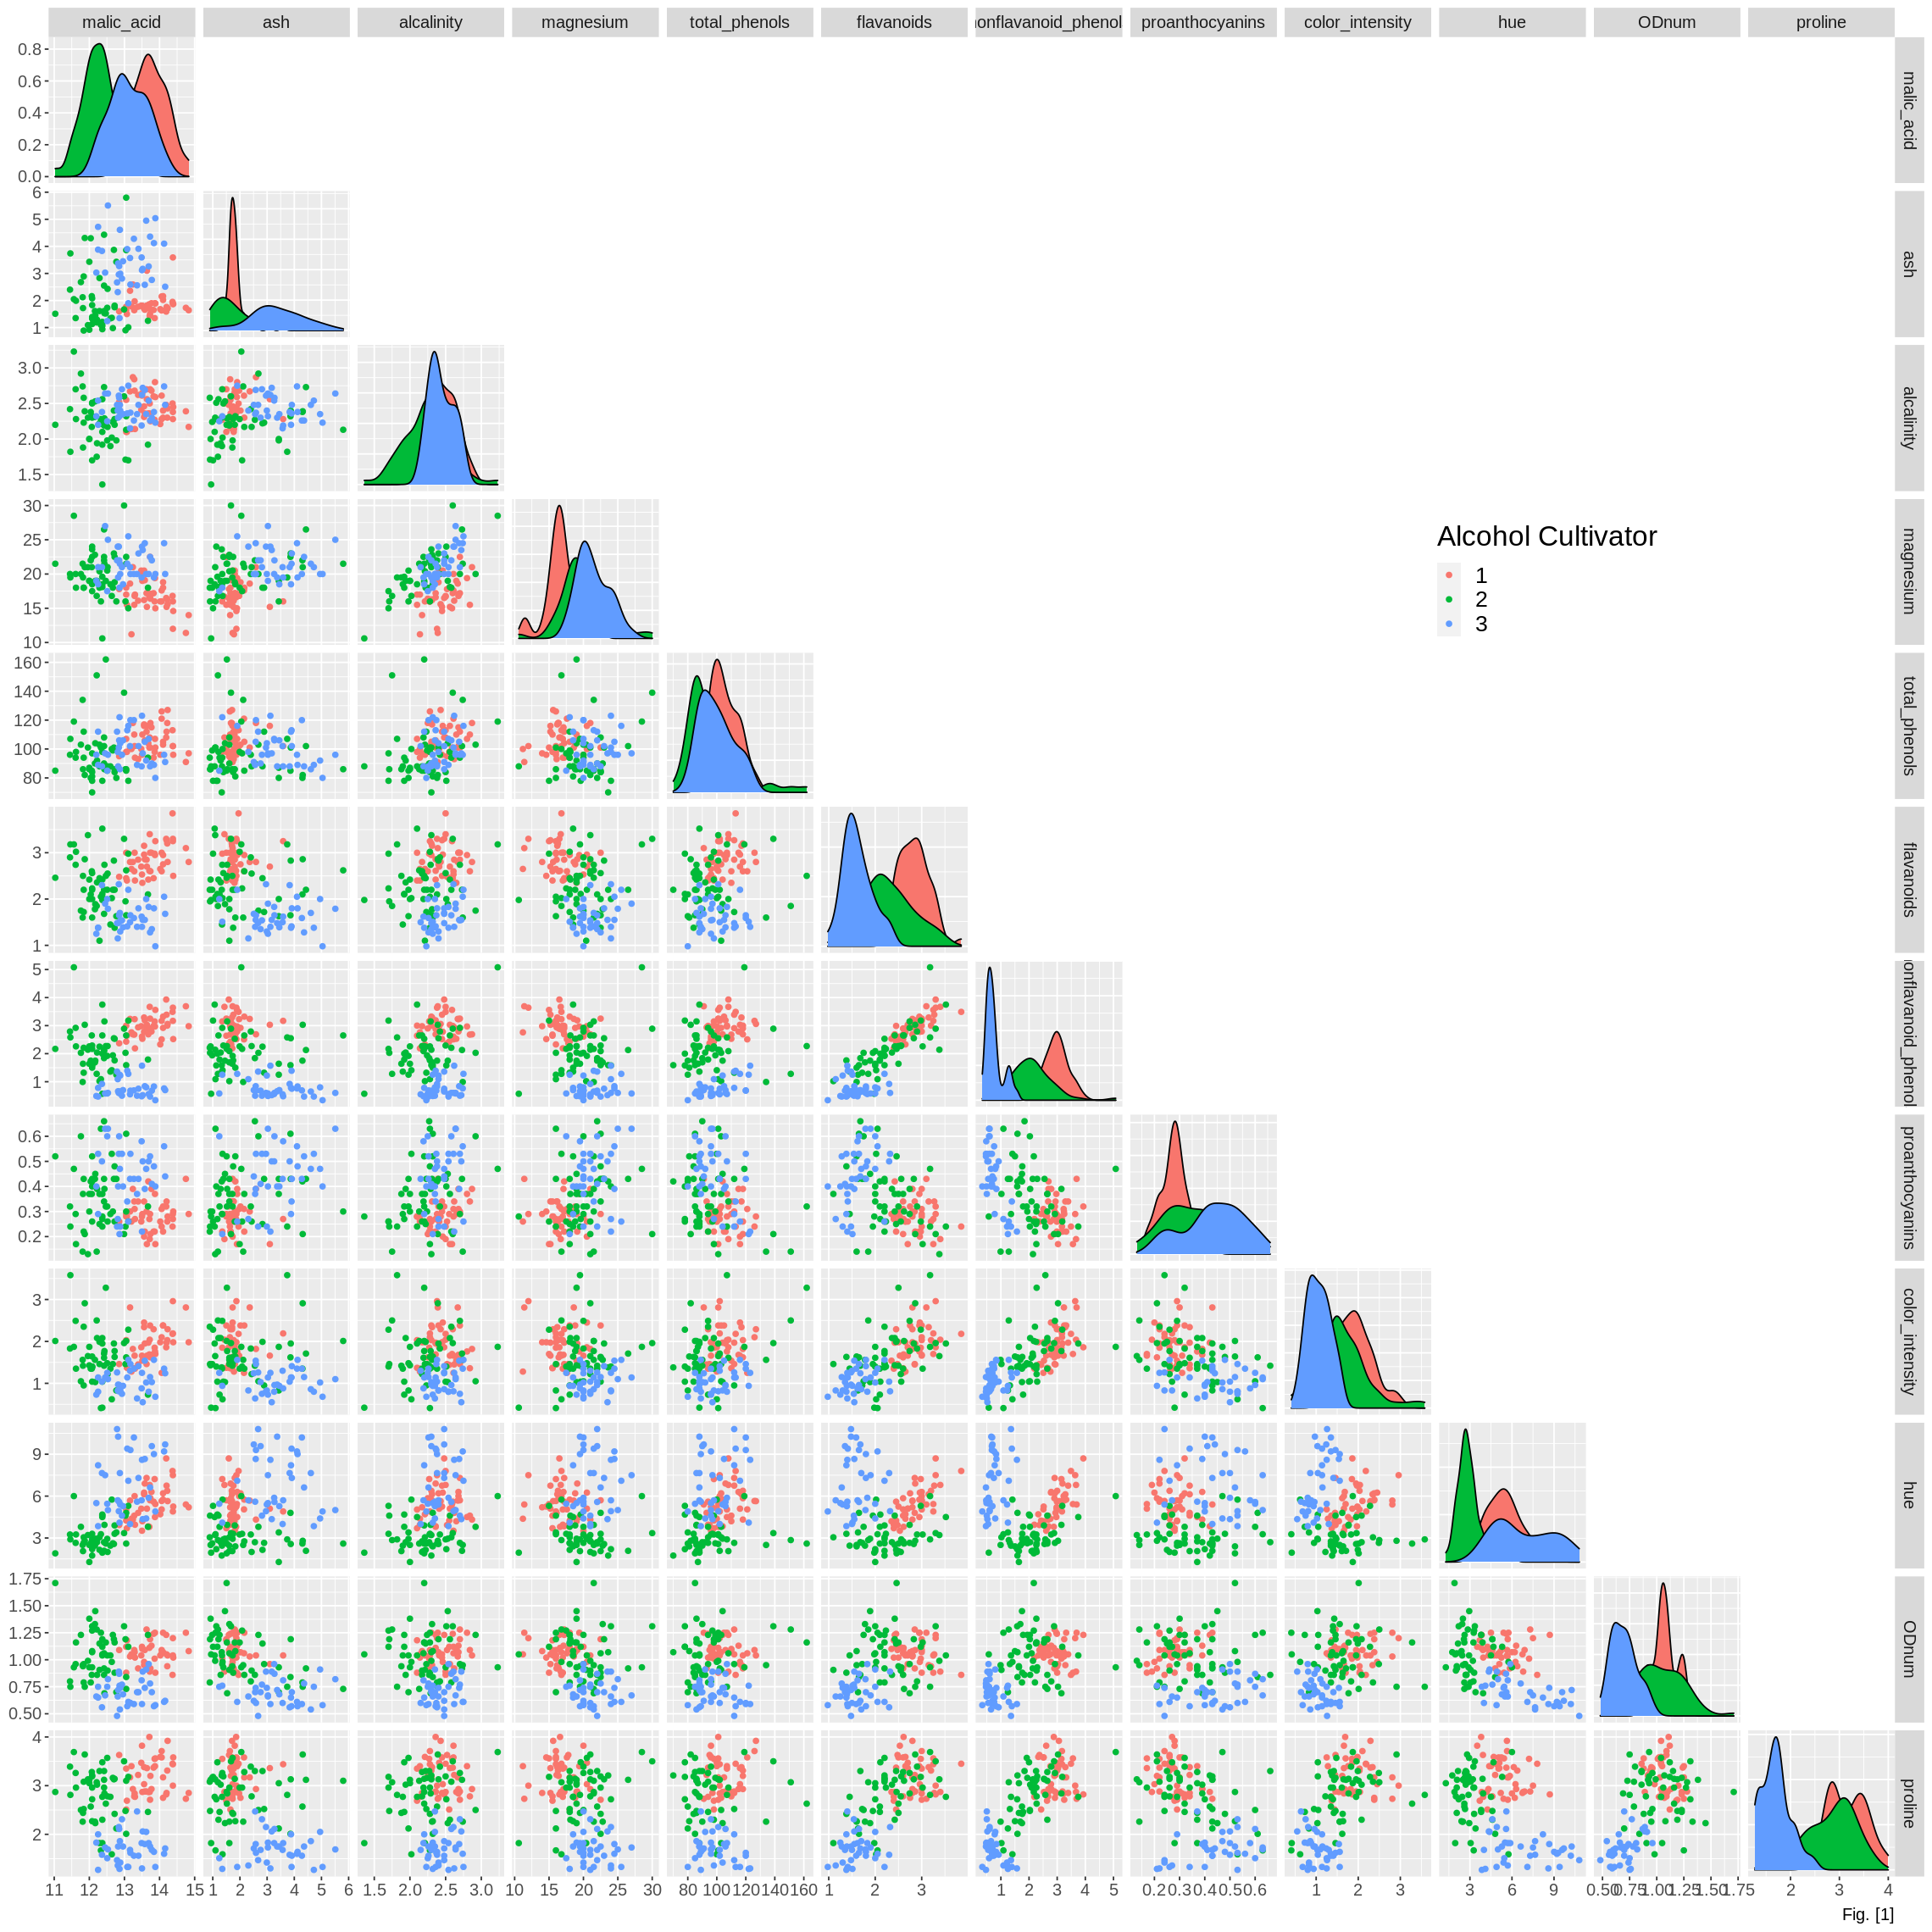

In [100]:
# scatter plots of the variables
options(repr.plot.width = 19, repr.plot.height = 19)
pairs_scatter_plot <- wine_training_data |>
    ggpairs(columns = 2:13, upper = "blank", ggplot2::aes(color = alcohol))+
    theme(text = element_text(size = 15), legend.position = "bottom") +
    labs(caption = "Fig. [1]", fill = "Alcohol Cultivator")


auxplot <- ggplot(wine_training_data, aes(x = nonflavanoid_phenols, y = hue, color = alcohol)) +
    geom_point() +
    labs(color = "Alcohol Cultivator") + 
    theme(text = element_text(size = 20))
mylegend <- grab_legend(auxplot)

grid.newpage()
grid.draw(pairs_scatter_plot)
vp = viewport(x=.8, y=.7, width=.35, height=.3) ## control legend position
pushViewport(vp)
grid.draw(mylegend)
upViewport()

The plot above uses ggpairs() to display a scatter plot of all the chemical compounds measured, giving insight into which are suitable for nearest neighbor classification.

### Methods
A classification model will be used, since the cultivator can only be one of three things. Though there are numerous variables, only two will be chosen, as not all are useful for prediction. 

By looking at the above visualization, pairs of variables can be identified as strong candidates for analysis. Examples are the plots of “Malic acid versus Proline” and “Non Flavonoid Phenols versus Hue”. Wines from each region are separated into relatively clear distinct areas in the plot.

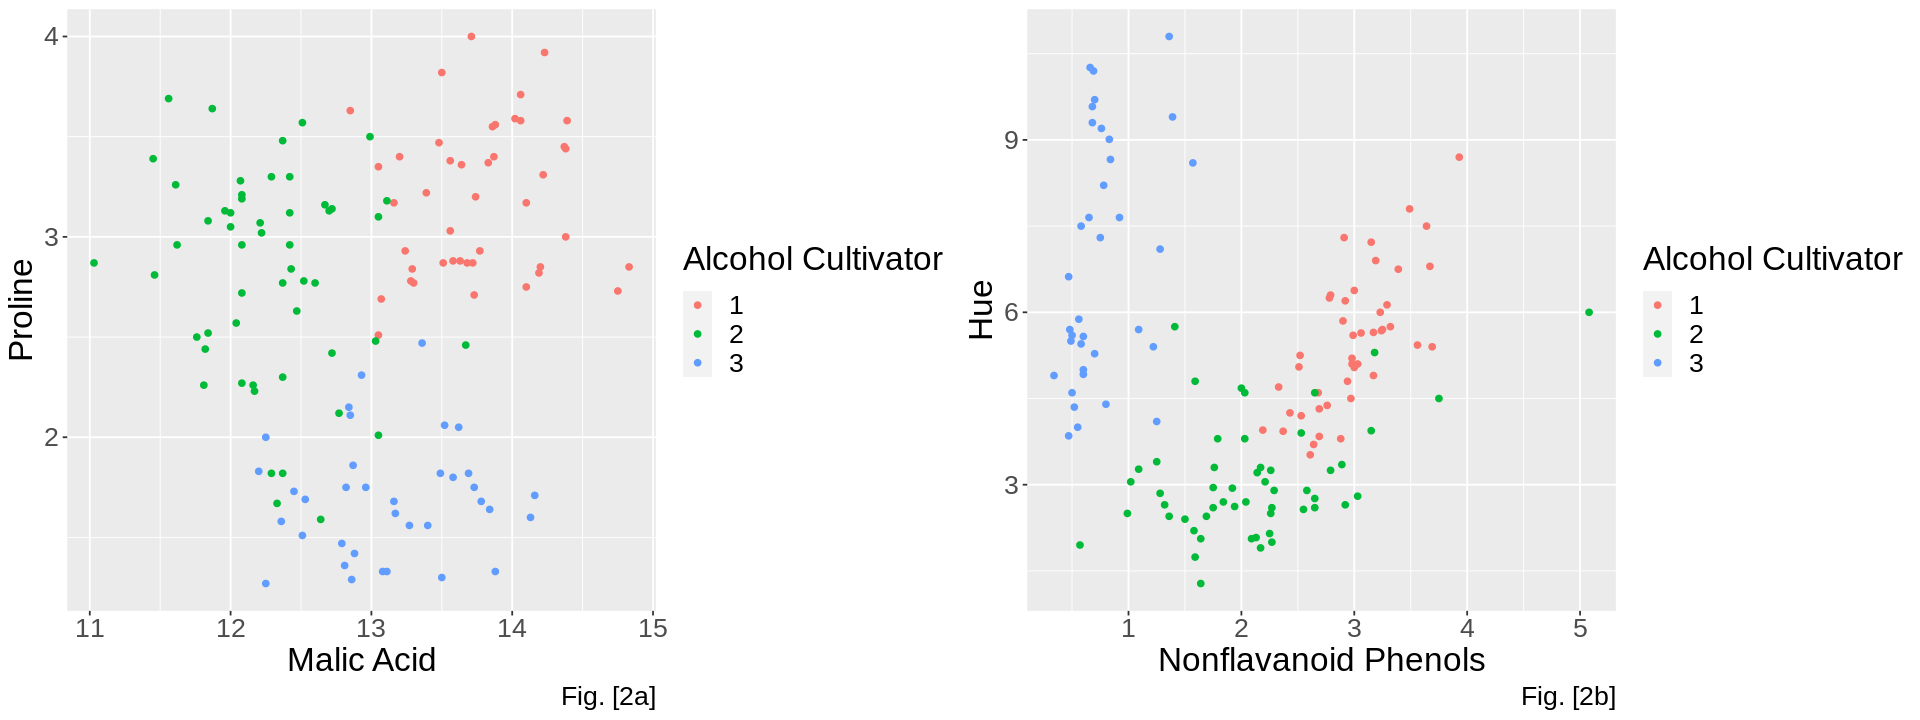

In [71]:
options(repr.plot.width = 16, repr.plot.height = 6)
malic_acid_proline_plot <- wine_training_data |>
    ggplot(aes(x = malic_acid, y = proline, color = alcohol)) +
    geom_point() +
    labs(x = "Malic Acid", y = "Proline", caption = "Fig. [2a]", color = "Alcohol Cultivator") + 
    theme(text = element_text(size = 20))


nonflavanoid_hue_plot <- wine_training_data |>
    ggplot(aes(x = nonflavanoid_phenols, y = hue, color = alcohol)) +
    geom_point() +
    labs(x = "Nonflavanoid Phenols", y = "Hue", caption = "Fig. [2b]", color = "Alcohol Cultivator") + 
    theme(text = element_text(size = 20))


plot_of_options <- plot_grid(malic_acid_proline_plot, nonflavanoid_hue_plot, ncol = 2)
plot_of_options

The graph above shows a scatter plot of two pairs of variables that are examples of potentially good predictors of wine cultivator.

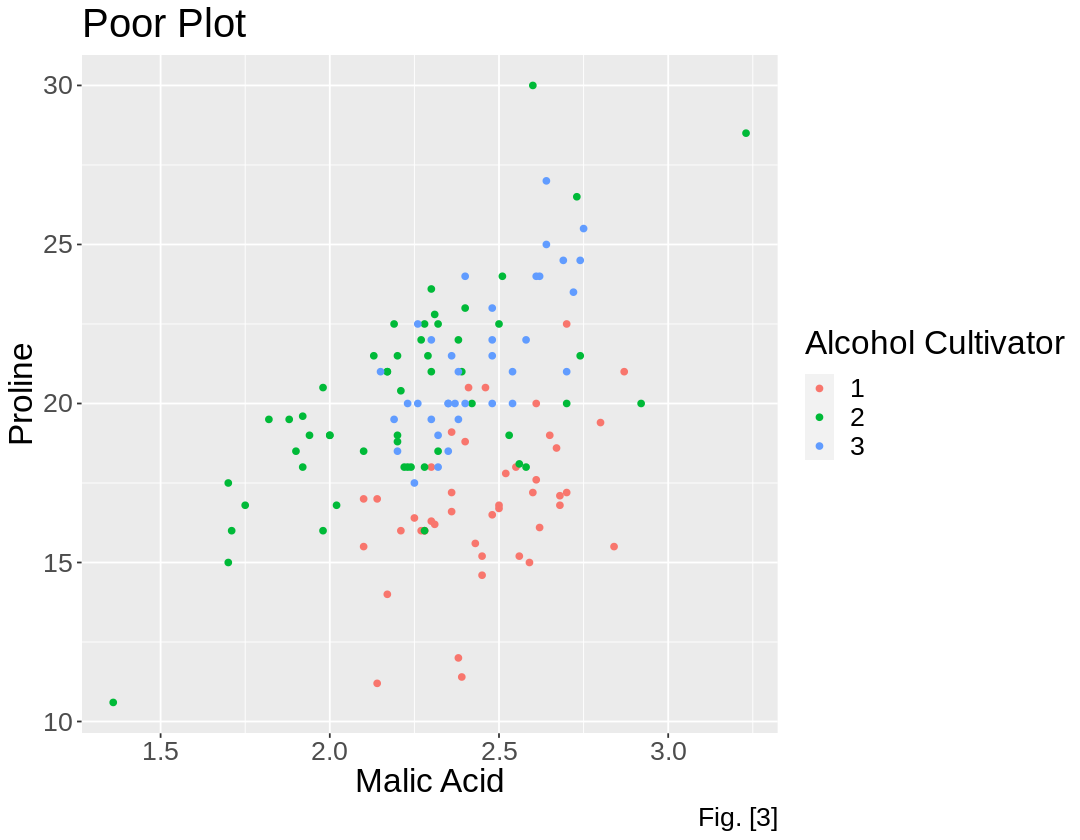

In [77]:
options(repr.plot.width = 9, repr.plot.height = 7)
alcalinity_magnesium_plot <- wine_training_data |>
    ggplot(aes(x = alcalinity, y = magnesium, color = alcohol)) +
    geom_point() +
    labs(x = "Malic Acid", y = "Proline", title = "Poor Plot", caption = "Fig. [3]", color = "Alcohol Cultivator") + 
    theme(text = element_text(size = 20))
alcalinity_magnesium_plot

The plot above shows an example of a pair of variables that would make a poor predictor of wine cultivator. 

While scaling and centering have not been performed yet, this provides a starting point. The choice is subjective, and others may make different choices. Nonetheless, the model will use the following to predict alcohol origin: Hue and Non Flavonoid Phenols. A more rigorous method of choosing the variables may be explored in a future project. 

# Model
### Cross Validation

In [10]:
set.seed(9999)

# cross validation for best neighbours to use
wine_training_data_selected <- wine_training_data |>
    select(alcohol, nonflavanoid_phenols, hue)

wine_vfold <- vfold_cv(wine_training_data_selected, v = 5, strata = alcohol)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('classification')

wine_recipe <- recipe(alcohol ~ ., data = wine_training_data_selected)  |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

grid_vals <- tibble(neighbors = seq( from = 1, to = 30))

num_results <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = wine_vfold, grid = grid_vals) |>
    collect_metrics()
#num_results

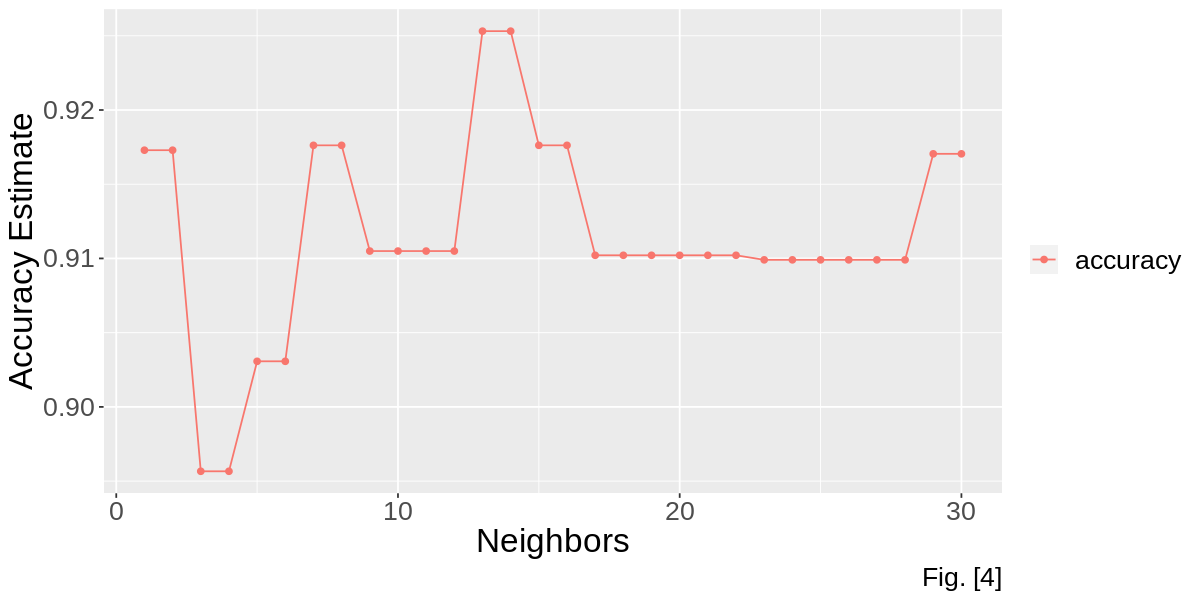

In [18]:
accuracies <- num_results |>
    filter(.metric == "accuracy")
#accuracies

options(repr.plot.width = 10, repr.plot.height = 5)
cross_val_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean, color = .metric)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", caption = "Fig. [4]") +
    theme(text = element_text(size = 20), legend.title = element_blank())
cross_val_plot

best_k <- accuracies |>
    filter(mean == max(mean))
#best_k


The graph above plots the estimated accuracy of nearest neighbor classification performed with different values for the number of neighbors. 5 fold cross validation was used to obtain these estimates on the training data. There is peak at 13 and 14 neighbors, both obtaining the same value for the accuracy estimate. 13 neighbors was chosen arbitrarily for the "best" number of neighbors. The training data is normalized before validating.

### Testing the Model

In [12]:
set.seed(9999) 
# making model with best neighbors
best_neighbors <- 13

wine_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = best_neighbors) |>
    set_engine('kknn') |>
    set_mode('classification')

wine_fit <- workflow() |>
    add_recipe(wine_recipe) |>
    add_model(wine_spec) |>
    fit(data = wine_training_data_selected)
wine_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(13,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.08270677
Best kernel: rectangular
Best k: 13

In [51]:
set.seed(9999) 
# testing model on test data
wine_predictions <- predict(wine_fit, wine_test_data) |>
    bind_cols(wine_test_data)
#wine_predictions 

wine_metrics <- wine_predictions |>
    metrics(truth = alcohol, estimate = .pred_class)
print("Table [5]")
wine_metrics

[1] "Table [5]"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9777778
kap,multiclass,0.9662921


The table above shows the accuracy estimate of the model when predicting the wine cultivator of the testing data, with an accuracy of approximately $97.78 \%$

In [52]:
wine_conf_mat <- wine_predictions |>
    conf_mat(truth = alcohol, estimate = .pred_class)
print("Table [6]")
wine_conf_mat

[1] "Table [6]"


          Truth
Prediction  1  2  3
         1 15  1  0
         2  0 17  0
         3  0  0 12

The table above shows the confusion matrix for the model's predictions on the testing data. There is only one error when predicting wine originating from wine cultivator $ \# 2$. This is visualized in a plot below.

# Data Analysis
To better understand the results, the data has been plotted with the decision of the classifier as the background color.

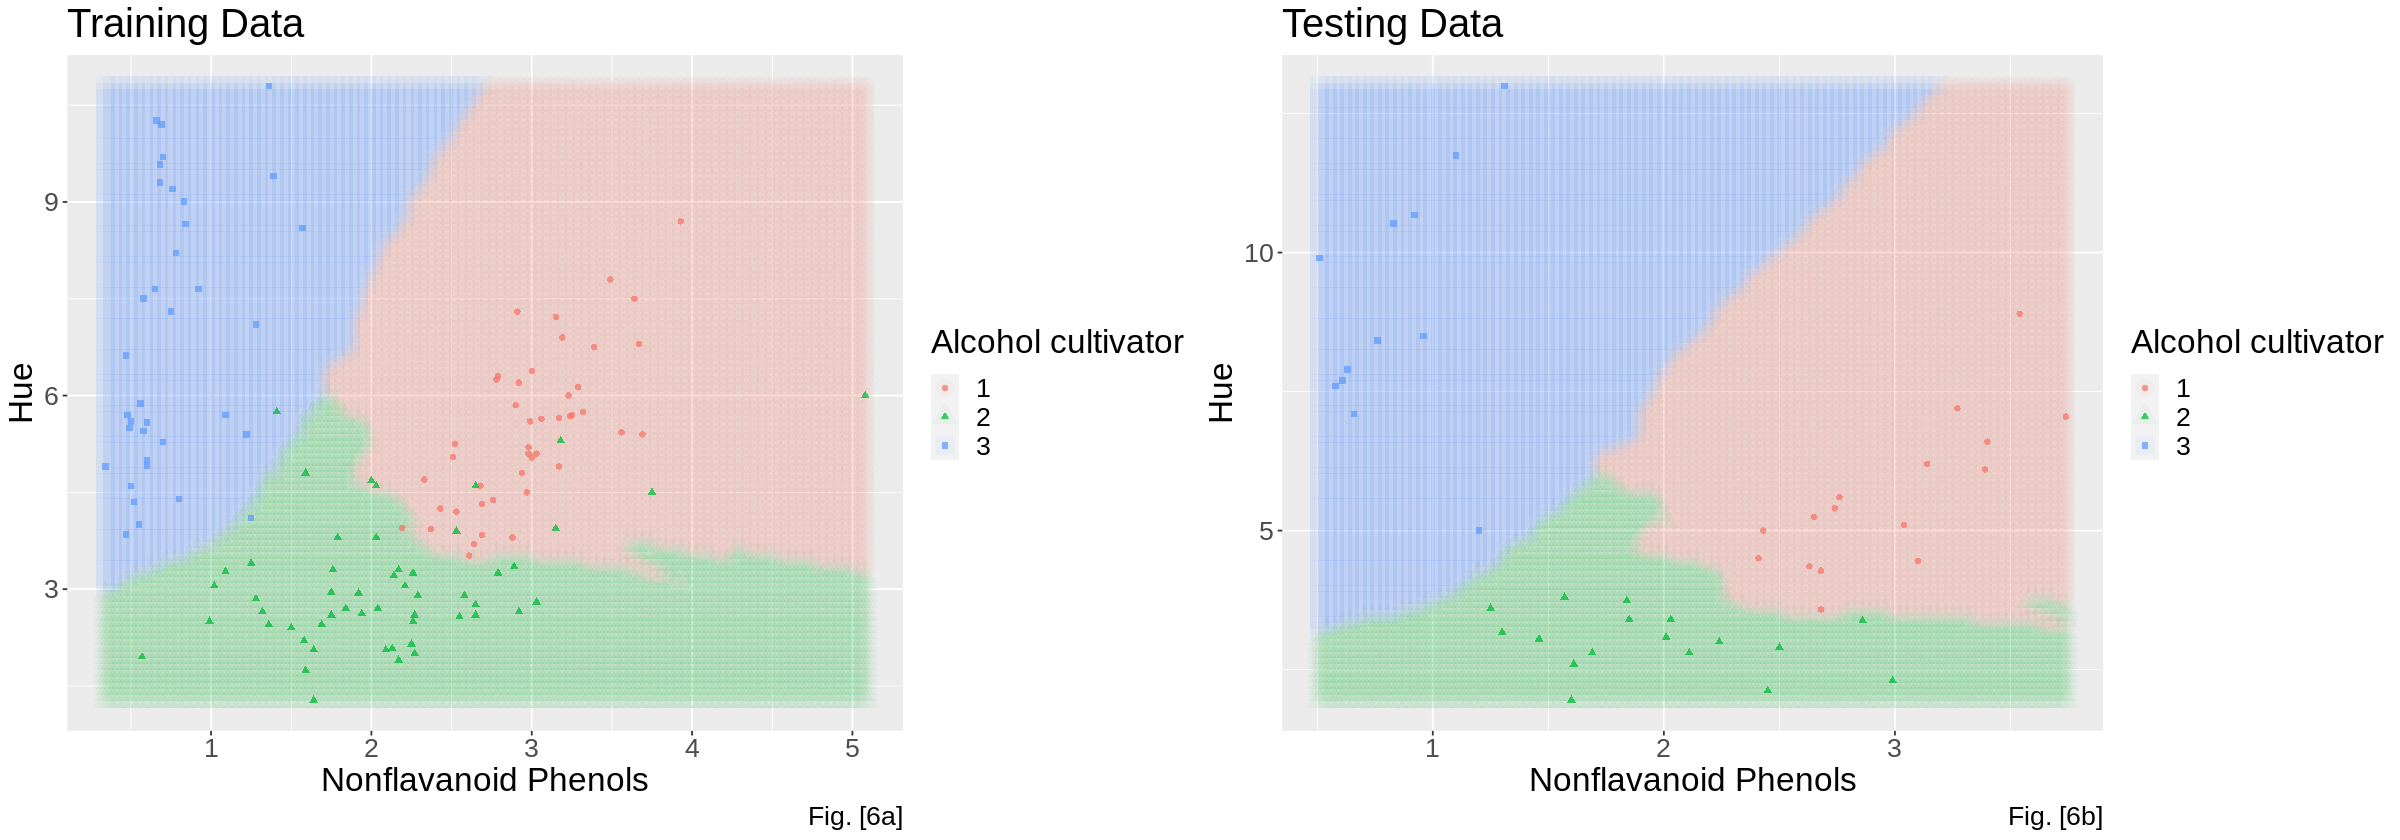

In [31]:
options(repr.plot.width = 10, repr.plot.height = 7)
nfp_grid <- seq(min(wine_predictions$nonflavanoid_phenols), 
                max(wine_predictions$nonflavanoid_phenols), 
                length.out = 100)
hue_grid <- seq(min(wine_predictions$hue), 
                max(wine_predictions$hue), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(nonflavanoid_phenols = nfp_grid, 
                                hue = hue_grid))

knnPredGrid <- predict(wine_fit, asgrid)

predictionTable <- bind_cols(knnPredGrid, asgrid) 

test_predictions_plot <- ggplot() + 
    geom_point(data = predictionTable, 
              mapping = aes(x = nonflavanoid_phenols,
                           y = hue,
                           color = .pred_class,
                           shape = .pred_class),
               alpha = 0.05,
               size = 5) +
    geom_point(data = wine_predictions,
              mapping = aes(x = nonflavanoid_phenols, 
                           y = hue,
                           color = .pred_class,
                           shape = .pred_class),
              alpha = 0.75) + 
    labs(x = "Nonflavanoid Phenols", y = "Hue", title = "Testing Data", color = "Alcohol cultivator", shape = "Alcohol cultivator", caption = "Fig. [6b]") + 
    theme(text = element_text(size = 20)) 

options(repr.plot.width = 10, repr.plot.height = 7)
nfp_grid <- seq(min(wine_training_data$nonflavanoid_phenols), 
                max(wine_training_data$nonflavanoid_phenols), 
                length.out = 100)
hue_grid <- seq(min(wine_training_data$hue), 
                max(wine_training_data$hue), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(nonflavanoid_phenols = nfp_grid, 
                                hue = hue_grid))

knnPredGrid <- predict(wine_fit, asgrid)

predictionTable <- bind_cols(knnPredGrid, asgrid) 

train_predictions_plot <- ggplot() + 
    geom_point(data = predictionTable, 
              mapping = aes(x = nonflavanoid_phenols,
                           y = hue,
                           color = .pred_class,
                           shape = .pred_class),
               alpha = 0.05,
               size = 5) +
    geom_point(data = wine_training_data,
              mapping = aes(x = nonflavanoid_phenols, 
                           y = hue,
                           color = alcohol,
                           shape = alcohol),
              alpha = 0.75) + 
    labs(x = "Nonflavanoid Phenols", y = "Hue", title = "Training Data", 
         color = "Alcohol cultivator", shape = "Alcohol cultivator", caption = "Fig. [6a]") + 
    theme(text = element_text(size = 20)) 

options(repr.plot.width = 20, repr.plot.height = 7)
plot_of_options <- plot_grid( train_predictions_plot, test_predictions_plot, ncol = 2)
plot_of_options

The plots above show their respective data as a scatter plot, and the predictions the model would make as the background color.

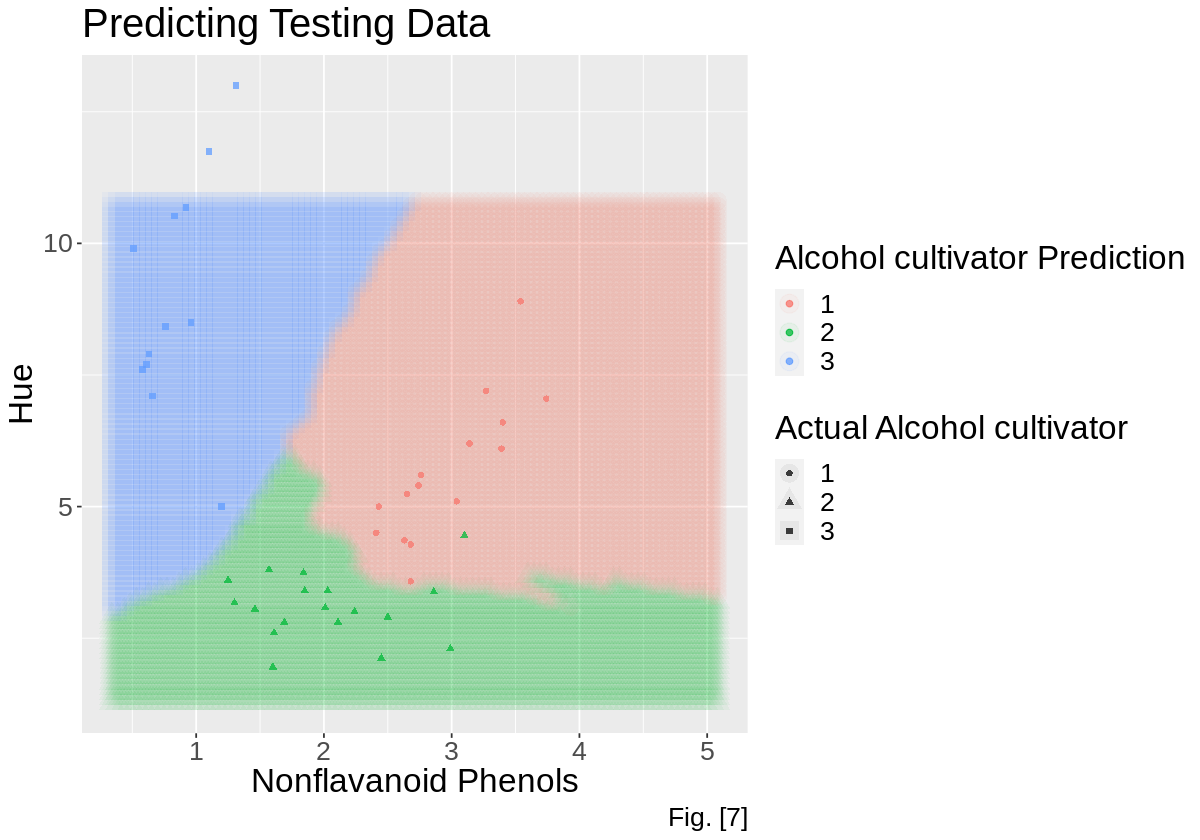

In [106]:
options(repr.plot.width = 10, repr.plot.height = 7)
predictions_original_comparison_plot <- ggplot() + 
    geom_point(data = predictionTable, 
              mapping = aes(x = nonflavanoid_phenols,
                           y = hue,
                           color = .pred_class,
                           shape = .pred_class),
               alpha = 0.05,
               size = 5) +
    geom_point(data = wine_predictions,
              mapping = aes(x = nonflavanoid_phenols, 
                           y = hue,
                           color = alcohol,
                           shape = alcohol),
              alpha = 0.75) +
    labs(x = "Nonflavanoid Phenols", y = "Hue", title = "Predicting Testing Data", 
         color = "Alcohol cultivator Prediction", shape = "Actual Alcohol cultivator", caption = "Fig. [7]") + 
    theme(text = element_text(size = 20)) 

predictions_original_comparison_plot

The plot above shows a scatter plot of the test data and its origin with the background color representing the prediction made by the model. The error the model made when assigning a value to a wine from the second wine cultivator is easily seen in the green triangle in the red zone. It is interesting to note that some points of the test data go beyond the range of data the model was trained on, leading to the uncolored region of the graph.